In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
dataset = pd.read_csv("../data/financials/financials_status_forms_clean2.csv")

## Creating new Features

### Financials features

In [4]:
dataset['equity_ratio'] = np.where(dataset['assets']<=0, np.nan, dataset['equity'] / dataset['assets'])
dataset['current_ratio'] = np.where(dataset['curr_liabilities']==0, 1, (dataset['current_assets'] / dataset['curr_liabilities']))
dataset['wc_assets'] = np.where(dataset['assets']<=0, np.nan,(dataset['current_assets'] - dataset['curr_liabilities']) / dataset['assets'])
dataset['net_profit_margin'] = np.where(dataset['net_sales']<=0, 0, dataset['results'] / dataset['net_sales'])
dataset['roa'] = np.where(dataset['assets']<=0, np.nan, dataset['results'] / dataset['assets'])
dataset['roe'] = np.where(dataset['equity']==0, 0, dataset['results'] / dataset['equity'])
dataset['asset_turnover'] = np.where(dataset['assets']<=0, np.nan, dataset['net_sales'] / dataset['assets'])

### Plotting the financials features

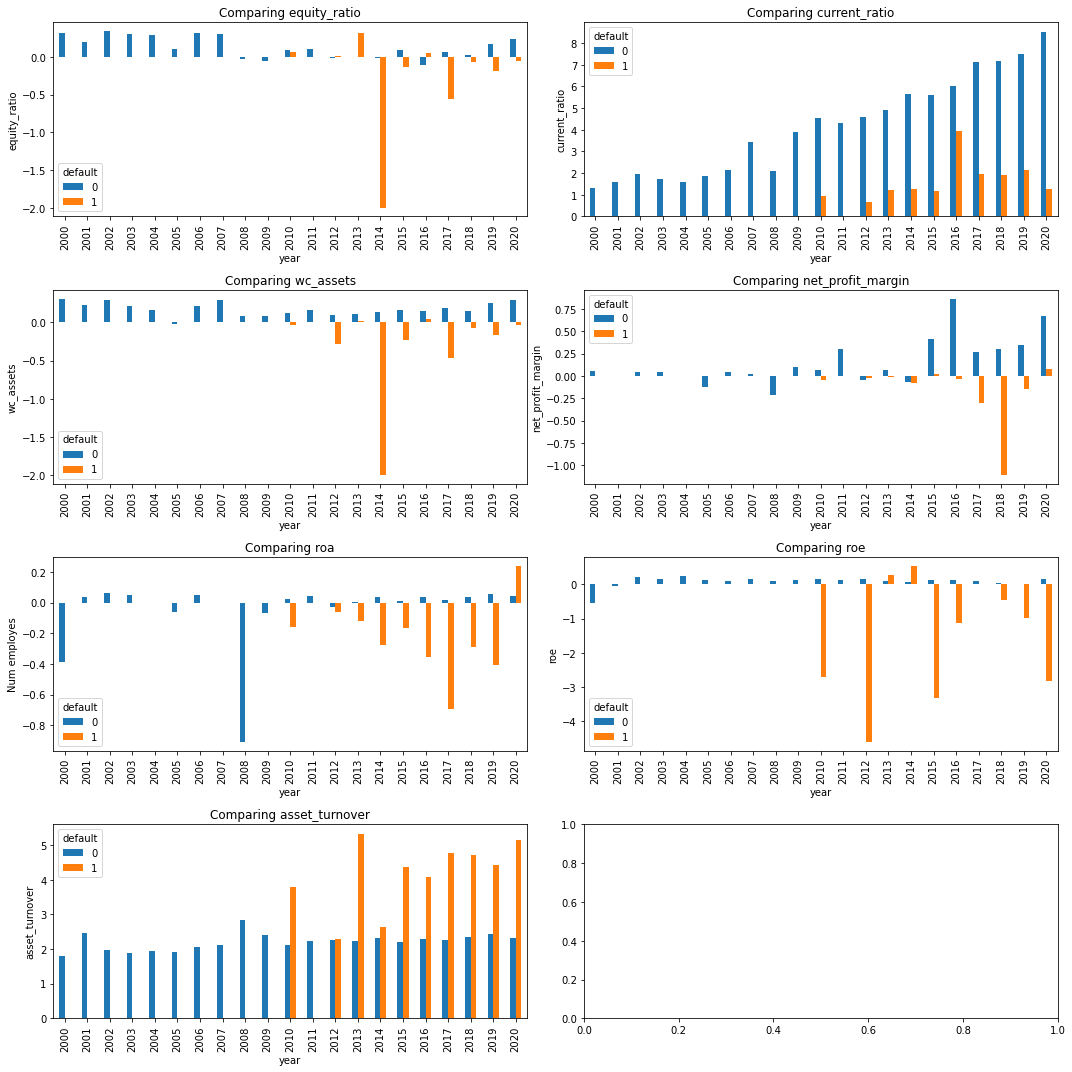

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2)
dataset.groupby(by=['year','default']).mean()['equity_ratio'].unstack().plot(kind='bar',
                                                                     title="Comparing equity_ratio",
                                                                     ylabel='equity_ratio',
                                                                    figsize=(15,15),
                                                                    ax = axes[0,0])
dataset.groupby(by=['year','default']).mean()['current_ratio'].unstack().plot(kind='bar',
                                                                     title="Comparing current_ratio",
                                                                     ylabel='current_ratio',
                                                                    figsize=(15,15),
                                                                     ax = axes[0,1])
dataset.groupby(by=['year','default']).mean()['wc_assets'].unstack().plot(kind='bar',
                                                                     title="Comparing wc_assets",
                                                                     ylabel='wc_assets',
                                                                    figsize=(15,15),
                                                                           ax=axes[1,0])
dataset.groupby(by=['year','default']).mean()['net_profit_margin'].unstack().plot(kind='bar',
                                                                     title="Comparing net_profit_margin",
                                                                     ylabel='net_profit_margin',
                                                                    figsize=(15,15),
                                                                        ax=axes[1,1])
dataset.groupby(by=['year','default']).mean()['roa'].unstack().plot(kind='bar',
                                                                     title="Comparing roa",
                                                                     ylabel='Num employes',
                                                                    figsize=(15,15),
                                                                         ax=axes[2,0])
dataset.groupby(by=['year','default']).mean()['roe'].unstack().plot(kind='bar',
                                                                     title="Comparing roe",
                                                                     ylabel='roe',
                                                                    figsize=(15,15),
                                                                    ax=axes[2,1])
dataset.groupby(by=['year','default']).mean()['asset_turnover'].unstack().plot(kind='bar',
                                                                     title="Comparing asset_turnover",
                                                                     ylabel='asset_turnover',
                                                                    figsize=(15,15),
                                                                    ax=axes[3,0])
plt.tight_layout()

### Growth Features

In [6]:
dataset['net_sales_growth'] = np.where(dataset.groupby('id')['net_sales'].shift(-1)==0, 1, 
                                  dataset['net_sales'] / dataset.groupby('id')['net_sales'].shift(-1) - 1)
dataset['profit_growth'] = np.where(dataset.groupby('id')['results'].shift(-1)==0, 1, 
                                  dataset['results'] / dataset.groupby('id')['results'].shift(-1) - 1)
dataset['assets_growth'] = np.where(dataset.groupby('id')['assets'].shift(-1)==0, 1, 
                                  dataset['assets'] / dataset.groupby('id')['assets'].shift(-1) - 1)
dataset['equity_growth'] = np.where(dataset.groupby('id')['equity'].shift(-1)==0, 1, 
                                  dataset['equity'] / dataset.groupby('id')['equity'].shift(-1) - 1)

### Plotting the growth features

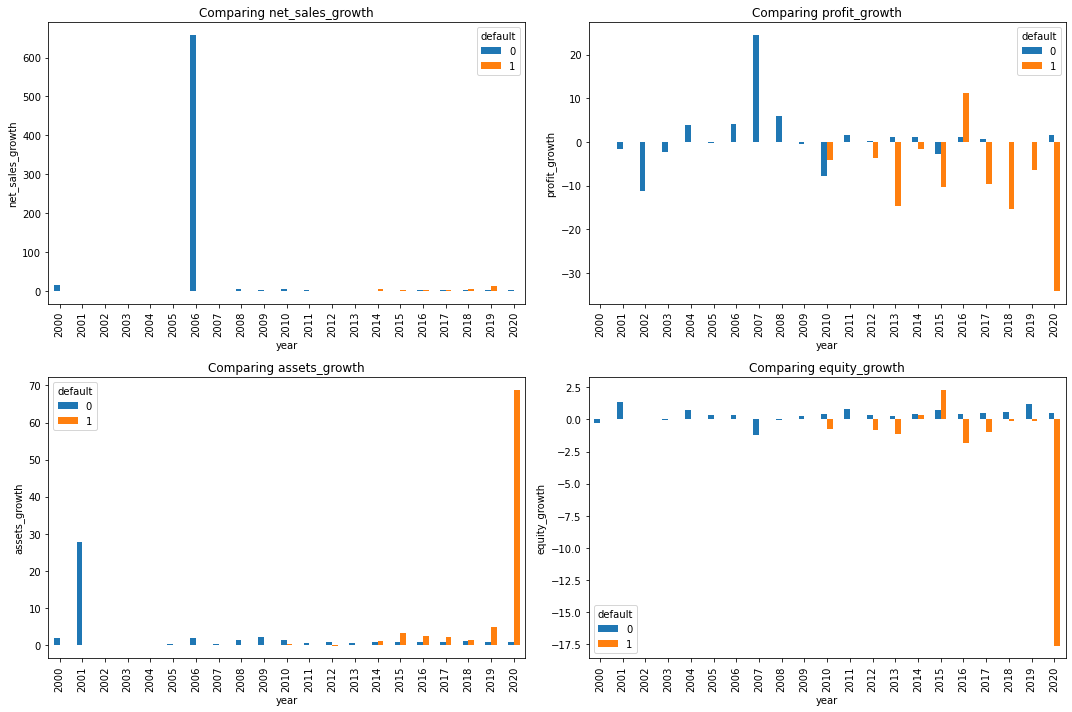

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
dataset.groupby(by=['year','default']).mean()['net_sales_growth'].unstack().plot(kind='bar',
                                                                     title="Comparing net_sales_growth",
                                                                     ylabel='net_sales_growth',
                                                                    figsize=(15,10),
                                                                    ax = axes[0,0])
dataset.groupby(by=['year','default']).mean()['profit_growth'].unstack().plot(kind='bar',
                                                                     title="Comparing profit_growth",
                                                                     ylabel='profit_growth',
                                                                    figsize=(15,10),
                                                                     ax = axes[0,1])
dataset.groupby(by=['year','default']).mean()['assets_growth'].unstack().plot(kind='bar',
                                                                     title="Comparing assets_growth",
                                                                     ylabel='assets_growth',
                                                                    figsize=(15,10),
                                                                           ax=axes[1,0])
dataset.groupby(by=['year','default']).mean()['equity_growth'].unstack().plot(kind='bar',
                                                                     title="Comparing equity_growth",
                                                                     ylabel='equity_growth',
                                                                    figsize=(15,10),
                                                                        ax=axes[1,1])
plt.tight_layout()

The growth variable create a large number of NaN values. These are created in the base years (the first years we have data on). I will impute these variable with the mean growth of that specific company

#### Imputing the base gowth years (all companies have this issue) (this only imputes the base year)

In [8]:
growth_columns = ['net_sales_growth','profit_growth','assets_growth','equity_growth']
for Id in dataset['id'].unique():
    growth_frame = dataset[(dataset['id']==Id)].iloc[:,-4:]
    
    # for each of the growth columns fill in the base years NaN with the mean
    for col in growth_columns:
        row_index = dataset[(dataset['id']==Id)].iloc[:,-4:][col].index[-1]
        col_index = col
        dataset.loc[row_index, col_index] = np.mean(dataset[(dataset['id']==Id)].iloc[:,-4:][col])
    

## Creating the features to be used

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478033 entries, 0 to 478032
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   company                   478033 non-null  object 
 1   id                        478033 non-null  int64  
 2   date                      478033 non-null  object 
 3   net_sales                 474999 non-null  float64
 4   other_sales               194756 non-null  float64
 5   op_profit_ebit            474998 non-null  float64
 6   prof_after_net_fin_items  474998 non-null  float64
 7   results                   474998 non-null  float64
 8   sub_unpaid_cap            475048 non-null  float64
 9   fixed_assets              475047 non-null  float64
 10  current_assets            475031 non-null  float64
 11  assets                    474923 non-null  float64
 12  equity                    475034 non-null  float64
 13  untaxed_reserves          475049 non-null  f

In [10]:
# getting the columns that will be used
# only use the numeric features
# 3-36 + 42 this includes the default column
# removing columns with lots on NaNs
column_indices = [1,3]
column_indices = column_indices + list(np.arange(5,18))
column_indices = column_indices + list(np.arange(23,25))
column_indices = column_indices + [28]
column_indices = column_indices + list(np.arange(30,37))
column_indices = column_indices + [42]
column_indices = column_indices + list(np.arange(48,59))
features_and_target = dataset.iloc[:,column_indices]

## Creating training and testing sets (all unbalanced)

In [11]:
## Removing NaNs
features_and_target.dropna(inplace=True)

<ipython-input-11-a0ec07b67534>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_and_target.dropna(inplace=True)


In [12]:
## Just some prelim stats
print(features_and_target.shape)
print(features_and_target['id'].nunique())
print(features_and_target[features_and_target['default']==1]['id'].nunique())
# should be around 2%
print((features_and_target[features_and_target['default']==1]['id'].nunique()/features_and_target['id'].nunique())*100)

(433736, 37)
62485
1459
2.3349603904937184


In [13]:
## Droping the id column
features_and_target.drop('id',axis=1,inplace=True)

/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
# get the non-defaulters
non_default = features_and_target[features_and_target['default']!=1]

# train test split on defaulters
default = features_and_target[features_and_target['default']==1]

# X and y for non-defaulters
X_non_default = non_default.drop('default',axis = 1)
y_non_default = non_default['default']

# train, test split on the non-defaulters
X_train_non_default, X_test_non_default, y_train_non_default, y_test_non_default = train_test_split(X_non_default, y_non_default, test_size=0.3, random_state=42)

# creating the X and y for defaulters
X_default = default.drop('default',axis = 1)
y_default = default['default']

# create the train and test sets for defaulters
X_train_default, X_test_default, y_train_default, y_test_default = train_test_split(X_default, y_default, test_size=0.3, random_state=42)

# create the X_train y_train, X_test and y_test to input to the model
X_train = X_train_non_default.append(X_train_default, ignore_index=True)
y_train = y_train_non_default.append(y_train_default,ignore_index=True)
X_test = X_test_non_default.append(X_test_default, ignore_index=True)
y_test = y_test_non_default.append(y_test_default, ignore_index=True)

In [15]:
# There are 1021 defaults in the training set
# need to use this in the balancing models to get good coverage
y_train.sum()

1021

## Default Random forest and comparing feature importances

#### Fit

In [16]:
rf_def = RandomForestClassifier(n_jobs=-1)
rf_def.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

#### Train error

In [17]:
train_pred = rf_def.predict(X_train)
prob_def_train = rf_def.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.9999835317211986
Precision = 1.0
Recall = 0.9951028403525954
F1 = 0.997545409916544
AUC = 1.0
Confusion Matrix = [[302593      0]
 [     5   1016]]


#### Test error

In [18]:
test_pred = rf_def.predict(X_test)
prob_def_test = rf_def.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.9966339281597271
Precision = 0.0
Recall = 0.0
F1 = 0.0
AUC = 0.8204131232800658
Confusion Matrix = [[129684      0]
 [   438      0]]


/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
## Massively overfit

### Feature importances

In [20]:
feature_imp = pd.Series(rf_def.feature_importances_,index=X_train.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


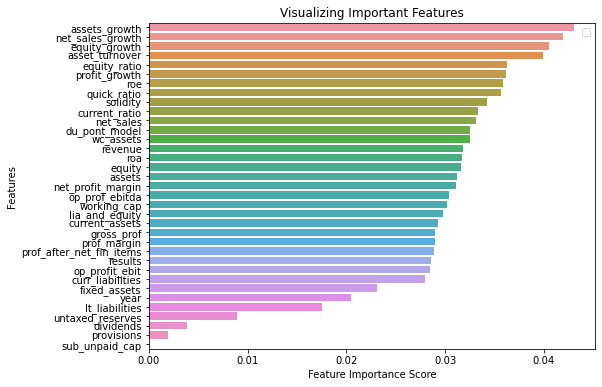

In [21]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,6))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Random forest with PD Model hyper-parameters (used 100 instead of 50 estimators)

#### Fit

In [23]:
rf_pd = RandomForestClassifier(n_estimators=100, random_state=23, min_samples_leaf=100, n_jobs=-1)
rf_pd.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=100, n_jobs=-1, random_state=23)

#### Train error

In [24]:
train_pred = rf_pd.predict(X_train)
prob_def_train = rf_pd.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.9966371774687597
Precision = 0.0
Recall = 0.0


/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = 0.0
AUC = 0.9807365850010746
Confusion Matrix = [[302593      0]
 [  1021      0]]


#### Test error

In [25]:
test_pred = rf_pd.predict(X_test)
prob_def_test = rf_pd.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.9966339281597271
Precision = 0.0
Recall = 0.0
F1 = 0.0
AUC = 0.9110523257869252
Confusion Matrix = [[129684      0]
 [   438      0]]


/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
## Just poor performance 

## Balanced random forest (default)

#### Fit

In [28]:
rf_bal = BalancedRandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
rf_bal.fit(X_train, y_train)

BalancedRandomForestClassifier(n_jobs=-1, random_state=42)

#### Train error

In [29]:
train_pred = rf_bal.predict(X_train)
prob_def_train = rf_bal.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.833469471104758
Precision = 0.019793726493738124
Recall = 1.0
F1 = 0.03881907875976655
AUC = 0.9868227704728804
Confusion Matrix = [[252032  50561]
 [     0   1021]]


#### Test error

In [30]:
test_pred = rf_bal.predict(X_test)
prob_def_test = rf_bal.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.8313505786876931
Precision = 0.017282398886744176
Recall = 0.8789954337899544
F1 = 0.03389830508474576
AUC = 0.9240005192107996
Confusion Matrix = [[107792  21892]
 [    53    385]]


## Balanced random forest (PD Model hyper-parameters)

#### Fit

In [31]:
rf_bal_pd = BalancedRandomForestClassifier(n_estimators=100, min_samples_leaf=100,random_state=42, n_jobs=-1)
rf_bal_pd.fit(X_train, y_train)

BalancedRandomForestClassifier(min_samples_leaf=100, n_jobs=-1, random_state=42)

#### Train error

In [32]:
train_pred = rf_bal_pd.predict(X_train)
prob_def_train = rf_bal_pd.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.8129401147509667
Precision = 0.014062418317737467
Recall = 0.7904015670910872
F1 = 0.027633200931379266
AUC = 0.8915394392327294
Confusion Matrix = [[246013  56580]
 [   214    807]]


#### Test error

In [33]:
test_pred = rf_bal_pd.predict(X_test)
prob_def_test = rf_bal_pd.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.8109620202579118
Precision = 0.014469453376205787
Recall = 0.821917808219178
F1 = 0.028438265265818784
AUC = 0.8991577648034935
Confusion Matrix = [[105164  24520]
 [    78    360]]


## Easy ensamble

#### Fit

In [34]:
ee = EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)
ee.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)

#### Train error

In [35]:
train_pred = ee.predict(X_train)
prob_def_train = ee.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.8252946175077566
Precision = 0.017008950124410442
Recall = 0.8971596474045054
F1 = 0.03338496583143508
AUC = 0.9354658249925757
Confusion Matrix = [[249655  52938]
 [   105    916]]


#### Test error

In [36]:
test_pred = ee.predict(X_test)
prob_def_test = ee.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.8228816034183305
Precision = 0.016385026737967913
Recall = 0.8744292237442922
F1 = 0.03216730357367824
AUC = 0.9241835510525831
Confusion Matrix = [[106692  22992]
 [    55    383]]


# Modeling with the board features as well

In [37]:
dataset = pd.read_csv("../data/financials/financials_status_forms_board_features.csv")

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478033 entries, 0 to 478032
Data columns (total 64 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   company                       478033 non-null  object 
 1   id                            478033 non-null  int64  
 2   date                          478033 non-null  object 
 3   net_sales                     474999 non-null  float64
 4   other_sales                   194756 non-null  float64
 5   op_profit_ebit                474998 non-null  float64
 6   prof_after_net_fin_items      474998 non-null  float64
 7   results                       474998 non-null  float64
 8   sub_unpaid_cap                475048 non-null  float64
 9   fixed_assets                  475047 non-null  float64
 10  current_assets                475031 non-null  float64
 11  assets                        474923 non-null  float64
 12  equity                        475034 non-nul

## Dropping nans to only have those companies with board information


In [39]:
data_board = dataset.iloc[dataset[dataset['number_of_board_members'].notnull()].index,:]

## Getting only the columns that we want

In [40]:
# getting the columns that will be used
# only use the numeric features
# 3-36 + 42 this includes the default column
# removing columns with lots on NaNs
column_indices = [1,3]
column_indices = column_indices + list(np.arange(5,18))
column_indices = column_indices + list(np.arange(23,25))
column_indices = column_indices + [28]
column_indices = column_indices + list(np.arange(30,37))
column_indices = column_indices + [42]
column_indices = column_indices + list(np.arange(48,64))

features_and_target = data_board.iloc[:,column_indices]

### Droping the id column

In [41]:
features_and_target.drop('id',axis = 1, inplace = True)

/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Removing the rest of the nans

In [42]:
features_and_target.dropna(inplace=True)

<ipython-input-42-8694d749a0f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_and_target.dropna(inplace=True)


In [43]:
features_and_target.shape

(69005, 41)

In [45]:
features_and_target[features_and_target['default']==1].shape[0]

160

## Creating the train and test sets

In [46]:
# get the non-defaulters
non_default = features_and_target[features_and_target['default']!=1]

# train test split on defaulters
default = features_and_target[features_and_target['default']==1]

# X and y for non-defaulters
X_non_default = non_default.drop('default',axis = 1)
y_non_default = non_default['default']

# train, test split on the non-defaulters
X_train_non_default, X_test_non_default, y_train_non_default, y_test_non_default = train_test_split(X_non_default, y_non_default, test_size=0.3, random_state=42)

# creating the X and y for defaulters
X_default = default.drop('default',axis = 1)
y_default = default['default']

# create the train and test sets for defaulters
X_train_default, X_test_default, y_train_default, y_test_default = train_test_split(X_default, y_default, test_size=0.3, random_state=42)

# create the X_train y_train, X_test and y_test to input to the model
X_train = X_train_non_default.append(X_train_default, ignore_index=True)
y_train = y_train_non_default.append(y_train_default,ignore_index=True)
X_test = X_test_non_default.append(X_test_default, ignore_index=True)
y_test = y_test_non_default.append(y_test_default, ignore_index=True)

## Default rf

In [47]:
rf_def = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_def.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

### Performance

#### Train

In [48]:
train_pred = rf_def.predict(X_train)

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, train_pred)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0
AUC = 1.0
Confusion Matrix = [[48191     0]
 [    0   112]]


#### Test

In [49]:
test_pred = rf_def.predict(X_test)
prob_def_test = rf_def.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.9976813834412134
Precision = 0.0
Recall = 0.0
F1 = 0.0
AUC = 0.7395959418675964
Confusion Matrix = [[20654     0]
 [   48     0]]


/home/matt/anaconda3/envs/scrapy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature importance

In [50]:
feature_imp = pd.Series(rf_def.feature_importances_,index=X_train.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


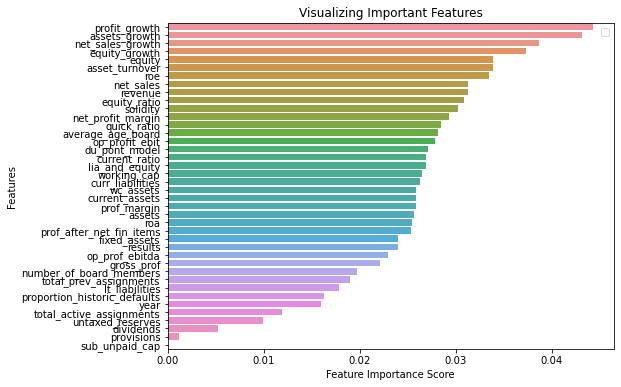

In [51]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,6))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Balanced rf

In [52]:
rf_bal = BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_bal.fit(X_train, y_train)

BalancedRandomForestClassifier(n_jobs=-1)

### Performance

#### Train

In [53]:
train_pred = rf_bal.predict(X_train)
prob_def_train = rf_bal.predict_proba(X_train)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_train, train_pred)}")

## Precision
print(f"Precision = {precision_score(y_train, train_pred)}")

## Recall
print(f"Recall = {recall_score(y_train, train_pred)}")

## F1
print(f"F1 = {f1_score(y_train, train_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_train, prob_def_train)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_train, train_pred)}")

Accuracy = 0.8284992650560007
Precision = 0.01333968556455455
Recall = 1.0
F1 = 0.026328161730136343
AUC = 0.9888261775316671
Confusion Matrix = [[39907  8284]
 [    0   112]]


#### Test

In [54]:
test_pred = rf_bal.predict(X_test)
prob_def_test = rf_bal.predict_proba(X_test)[:, 1:2]

## Accuracy
print(f"Accuracy = {accuracy_score(y_test, test_pred)}")

## Precision
print(f"Precision = {precision_score(y_test, test_pred)}")

## Recall
print(f"Recall = {recall_score(y_test, test_pred)}")

## F1
print(f"F1 = {f1_score(y_test, test_pred)}")

## AUC
print(f"AUC = {roc_auc_score(y_test, prob_def_test)}")

## Confusion Matrix
print(f"Confusion Matrix = {confusion_matrix(y_test, test_pred)}")

Accuracy = 0.8302096415805236
Precision = 0.012102448634956376
Recall = 0.8958333333333334
F1 = 0.02388225492918634
AUC = 0.925886026919725
Confusion Matrix = [[17144  3510]
 [    5    43]]


### ROC Curve

Text(0.5, 1.0, 'ROC Curve')

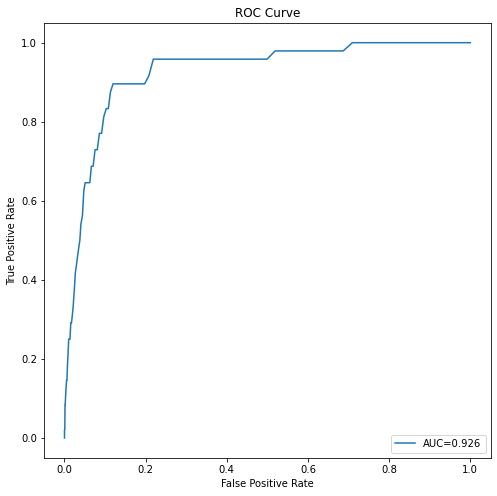

In [55]:
f, ax = plt.subplots(figsize=(8,8))
fpr, tpr, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1:2])
auc = roc_auc_score(y_test, rf_bal.predict_proba(X_test)[:, 1:2])
ax.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
ax.legend(loc='lower right')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

### Feature importance

In [56]:
feature_imp = pd.Series(rf_bal.feature_importances_,index=X_train.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


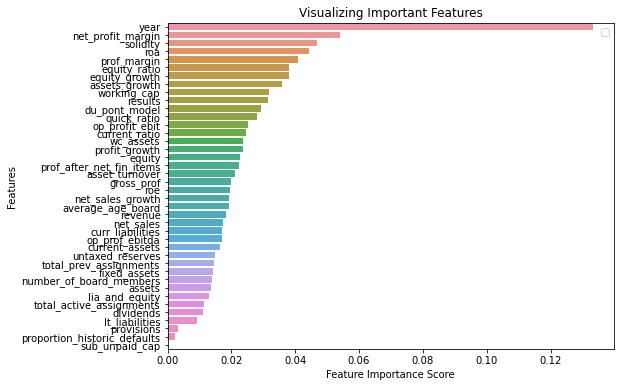

In [57]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,6))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()